# 1. Описание проекта

Аналитики заметили, что происходит отток клиентов банка. Нужно построить модель машинного обучения, которая предскажет, уйдет ли клиент из банка или нет.

**Целью проекта**: максимизация `F1-меры`

Признаки
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак
* Exited — факт ухода клиента

# 2. Подготовка данных

In [1]:
# импорт всех библиотек, необходимых для работы
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from tqdm.notebook import tqdm

## 2.1. Выгрузка данных и общая информация

In [3]:
data = pd.read_csv('Churn.csv')

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


### 2.1.1 Предвариельные выводы по данным

Исходя из предворительного ознакомления с данными можно сделать следующие выводы:
* Для обучения модели предсказывающей поведение клиента врядли понадобятся признаки: `RowNumber`, `CustomerId`, `Surname`. От этих признаков можно избавиться
* Только в одном призанке встречаются пропуски - в признаке `Tensure` (Сколько лет человек является клиентом банка). Данный признак может коррелировать с тем, собирается человек уходить с банка или нет. Рассмотри этот столбец подробнее.
* В данных не наблюдается аномально больших или маленьких значений. В колонках `CreditScore`, `Age`, `Tenure`, `EstimatedSalary` медиана примерно равна среднему.
* В столбце `balance` медиана больше среднего. Значение ноль первого квартиля говорит нам о том что 25% клиентов имеют нулевой баланс на счету, что может сигнализировать о их желании уйти. Либо же это наоборот новые клиенты.
* В среднем клиент банка пользуется 1 или 2 услугами.
* 70% клиентов обладают кредитной картой
* Примерно половину клиенов банк отмечает как активных
* Около 20% клиентов из исходного датасета перестали пользоваться услугами банка (наблюдается дисбаланс классов для целевого признака)
* Данные собраны всего по трем странам
* Клиентов банка мужского пола на 10% больше женского

## 2.2 Обработка данных

### 2.2.1 Удаление ненужных признаков

In [8]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### 2.2.2 Смотрим на `Geography`

In [9]:
data['Geography'].value_counts(normalize=True)

,proportion
Geography,
France,0.5014
Germany,0.2509
Spain,0.2477


Видим, что 50% клиентов банка из Франции, по 25% приходится на Испанию и Германию

### 2.2.3 Смотрим на `Tenure`

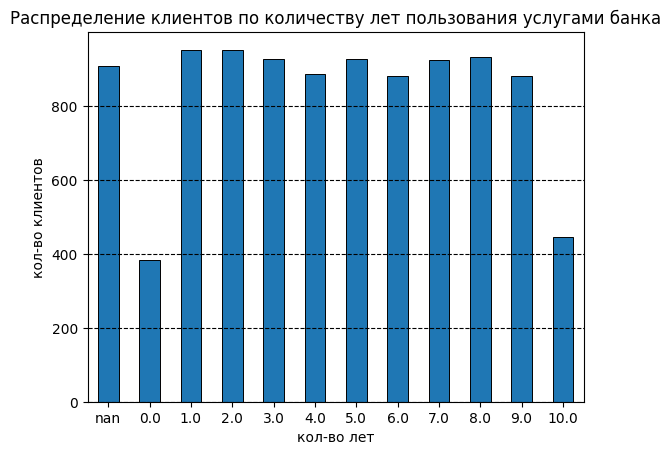

In [10]:
(data['Tenure']
 .value_counts(dropna=False)
 .sort_index(na_position='first')
 .plot(kind='bar', edgecolor='black', linewidth=0.7)
 )

plt.title('Распределение клиентов по количеству лет пользования услугами банка', )
plt.ylabel('кол-во клиентов')
plt.xlabel('кол-во лет')
plt.xticks(rotation=0)
plt.grid(axis='y', color='black', linestyle='--')
# plt.yticks(range(0, 951, 100))
plt.show()

Видим, что распределение клиентов по годам, сколько они пользоавлись банков неоднородно, но чем то отдаленно напоминает равномерное. Видим провалы по количеству клиентов, пользующихся банком 0 и 10 лет. Также более чем для 800 клиентов почему-то отсутствует значение данного столбца. Посмотри на данное распределние по странам

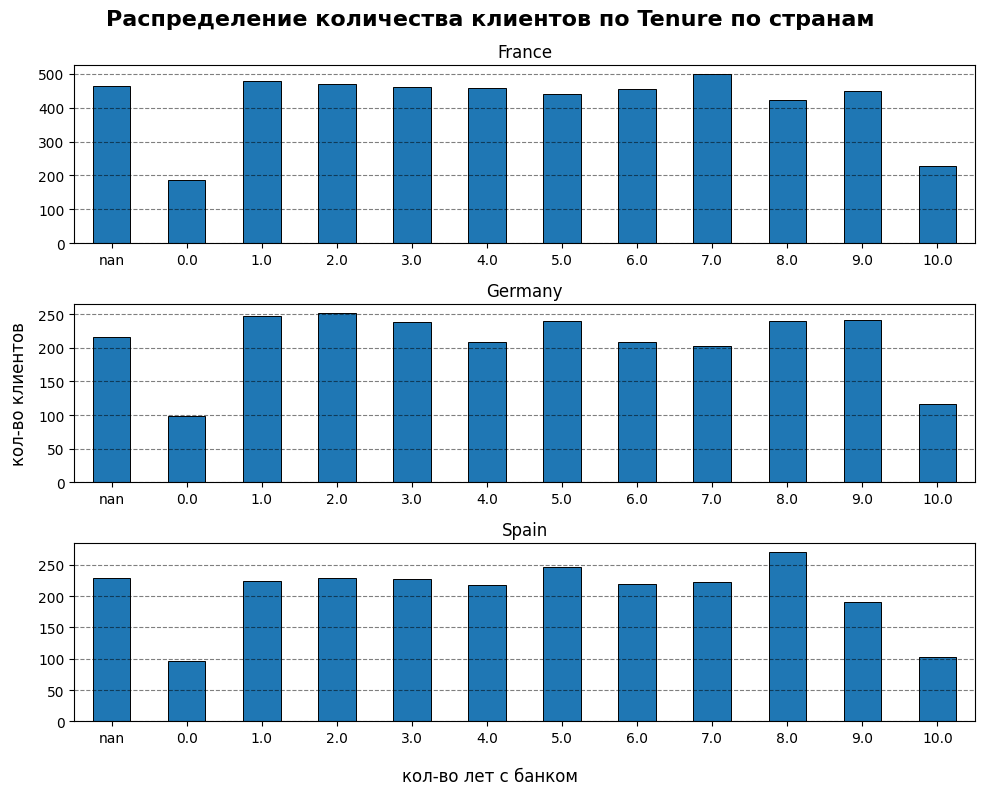

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

for i, country in enumerate(['France', 'Germany', 'Spain']):
    (data.loc[data['Geography'] == country, 'Tenure']
    .value_counts(dropna=False)
    .sort_index(na_position='first')
    .plot(kind='bar',
        edgecolor='black',
        linewidth=0.7,
        ax=axes[i],
        title=country)
    )
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].set_xlabel('')
    axes[i].grid(axis='y', color='black', alpha=0.5, linestyle='--')


fig.suptitle('Распределение количества клиентов по Tenure по странам', fontsize = 16, fontweight='bold')
fig.supxlabel('кол-во лет с банком')
fig.supylabel('кол-во клиентов')
plt.tight_layout()
plt.show()

Видим что в странах по отдельности ситуация одинаковая. Такие же провалы на 0 и 10. Примерно одинаковое соотношение пропущенных значений. Посмотри на описательные статистики данных с пропусками и данных без пропусков.

In [12]:
(data[(data['Tenure'].notna()) & (data['Tenure'] != 0) & (data['Tenure'] != 10)]
 .describe()
 )

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000
mean,650.631732,38.919400,4.958732,76514.539622,1.532736,0.707249,0.514825,100066.079340,0.202348
std,96.412823,10.542546,2.590762,62435.769840,0.581621,0.455053,0.499810,57691.147036,0.401774
min,350.000000,18.000000,1.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51115.100000,0.000000
50%,652.000000,37.000000,5.000000,97259.250000,1.000000,1.000000,1.000000,100015.790000,0.000000
75%,717.000000,44.000000,7.000000,127638.135000,2.000000,1.000000,1.000000,149543.460000,0.000000
max,850.000000,92.000000,9.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [13]:
data[data['Tenure'].isna()].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


Видиим, что основные описательные статистики практически не изменились. В целом и отдельно по странам также нет различий. Так как нам нужны данные этого признака, следует предпринять какие то меры по пропускам. Есть предположение, исходя и распредления, что половина пропущенных значений приходится на клиентов с 0 лет в банке и другая половина с 10 годами в банке (и тогда получаем что-то похожее на равномерное распределение по времени, проведенном с банком, для клиентов). Другое предположение, что изначально даннные распределены нормально, и пропущенные значения, стоит "нормально раскидать" по диопазону от 1 до 9. Для дальнейшей раоты просто удалим записи с пропусками.

In [14]:
data = data.dropna()
data.shape

(9091, 11)

## 2.3 Подготовка данных для обучения моделей

### 2.3.1 Кодирование категориальных переменных

Для категоризации воспользуемся техникой OHE

In [15]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2.0,125510.82,1,1,1,79084.10,0,False,True,False


Видим что переменныые `Geography` и `Gender` стали dummy-переменными

### 2.3.2  Разделение выборки на обучающую и валидационную


In [16]:
features = data.drop('Exited', axis=1)
target = data['Exited']

features_train_bad, features_valid, target_train_bad, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

### 2.3.3  Масштабирование количественных переменных

In [17]:
scaler = StandardScaler()

# выделяем количественные признаки
numeric = ['CreditScore', 'Tenure', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# учим скейлер
scaler.fit(features_train_bad[numeric])

# масштабируем признаки для обучающей и валидацинное выборки
features_train_bad[numeric] = scaler.transform(features_train_bad[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

### 2.3.4 Борьба с дисбалансом классов

Обучим модели и сравним метрики с учетом дисбаланса и без.

In [18]:
def downsample(features, target, fraction):
    # выделяем на обучающей выборке записи с классами 0 и 1 для обучающих и целевого призаков
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_zeros = features_zeros.sample(frac=fraction, random_state=12345)
    target_zeros = target_zeros.sample(frac=fraction, random_state=12345)

     # уменьшаем размер выборки за удаления записей с частым классом
    features_downsampled = pd.concat([features_zeros, features_ones])
    target_downsampled = pd.concat([target_zeros, target_ones])

    # перемешиваем выборку
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [19]:
def upsample(features, target, repeat):

    # выделяем на обучающей выборке записи с классами 0 и 1 для обучающих и целевого призаков
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # увеичиваем размер выборки за счет добавления записей с редким классом
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    # Перемешиваем выборку
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
        )

    return features_upsampled, target_upsampled

In [20]:
repeat = 1 + int(((1 - target.mean()) // target.mean()))
features_train_upsampled, target_train_upsampled = upsample(
    features_train_bad, target_train_bad, repeat=repeat)

fraction = 1 / repeat
features_train_downsampled, target_train_downsampled = downsample(
    features_train_bad, target_train_bad, fraction=fraction)




In [22]:
features_train_stratified, features_valid_stratified, target_train_stratified, target_valid_stratified = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=target
)

scaler = StandardScaler()

scaler.fit(features_train_stratified[numeric])

features_train_stratified[numeric] = scaler.transform(features_train_stratified[numeric])
features_valid_stratified[numeric] = scaler.transform(features_valid_stratified[numeric])

# 3. тестирование моделей

## 3.1 Тестирование различных моделей с учетом дисбаланса классов и без

Протестируем на трех моделях (дереве решений, логистической регрессии и алгоритме случайного леса) для различных обучающих выборок и сравним результаты

In [23]:
def f1_models(features_train, target_train, features_valid, target_valid, class_weight=None):
    models_discp = ['дерево решений', 'случайный лес', 'логистическая регрессия']
    models_algos = [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]
    f1_models = []

    for i, algos in enumerate(models_algos):
        model = (algos(random_state=12345, solver='liblinear', class_weight=class_weight) if i == 2
                 else algos(random_state=12345, class_weight=class_weight)
                 )
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        f1_models.append(f1)

    return f1_models

Для каждой модели и для каждой выборки составим матрицу из значений F-меры

In [24]:
models_names = ['дерево решений', 'случайный лес', 'логистическая регрессия']

models_matrix = (pd
                 .DataFrame(index=['дерево решений', 'случайный лес', 'логистическая регрессия'],
                            columns=['disbalansed', 'upsampled', 'downsampled', 'stratify', 'class_weight', 'class_weight_and_stratify'])
)

In [25]:
# вектор значений F-меры для выборки с дисбалансом
f1_disbalanced = f1_models(features_train_bad, target_train_bad,
                           features_valid, target_valid, class_weight=None)
f1_disbalanced = pd.Series(f1_disbalanced, index=models_names)
models_matrix['disbalansed'] = f1_disbalanced

# вектор значений F-меры для увеличенной выборки
f1_upsampled = f1_models(features_train_upsampled, target_train_upsampled,
                         features_valid, target_valid, class_weight=None)
f1_upsampled = pd.Series(f1_upsampled, index=models_names)
models_matrix['upsampled'] = f1_upsampled

# вектор значений F-меры для выборки уменьшенной
f1_downsampled = f1_models(features_train_downsampled, target_train_downsampled,
                           features_valid, target_valid, class_weight=None)
f1_downsampled = pd.Series(f1_downsampled, index=models_names)
models_matrix['downsampled'] = f1_downsampled

# вектор значений F-меры для сратифицированной выборки
f1_stratified = f1_models(features_train_stratified, target_train_stratified,
                          features_valid_stratified, target_valid_stratified,
                          class_weight=None)
f1_stratified = pd.Series(f1_stratified, index=models_names)
models_matrix['stratify'] = f1_stratified

# вектор значений F-меры для выборки со взвешенными классами
f1_class_weight = f1_models(features_train_bad, target_train_bad,
                            features_valid, target_valid, class_weight='balanced')
f1_class_weight = pd.Series(f1_class_weight, index=models_names)
models_matrix['class_weight'] = f1_class_weight

# вектор значений F-меры для выборки со взвешенными и стратифицированными классами
f1_class_weight_stratified = f1_models(features_train_stratified, target_train_stratified,
                            features_valid_stratified, target_valid_stratified, class_weight='balanced')
f1_class_weight_stratified = pd.Series(f1_class_weight_stratified, index=models_names)
models_matrix['class_weight_and_stratify'] = f1_class_weight

models_matrix

,disbalansed,upsampled,downsampled,stratify,class_weight,class_weight_and_stratify
дерево решений,0.471958,0.493092,0.470845,0.519507,0.490811,0.490811
случайный лес,0.565158,0.594724,0.583541,0.611040,0.552595,0.552595
логистическая регрессия,0.308970,0.508009,0.511094,0.351145,0.511337,0.511337


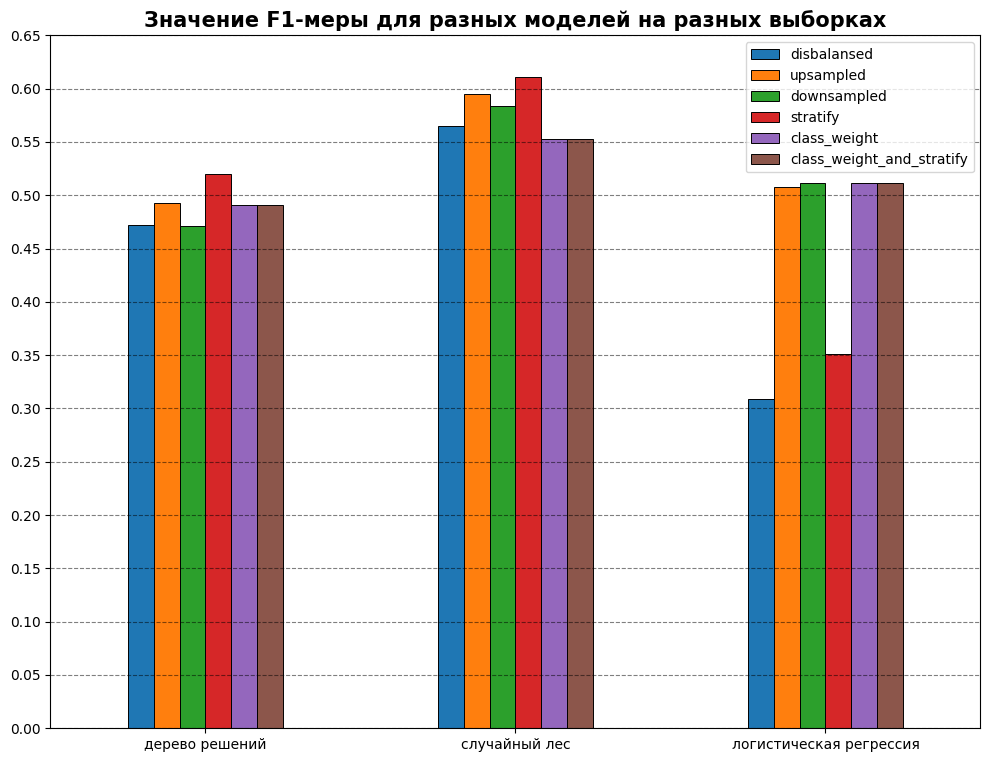

In [26]:
models_matrix.plot(kind='bar', figsize=(12, 9), edgecolor='black', linewidth=0.7)

plt.title('Значение F1-меры для разных моделей на разных выборках', fontsize=15, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid(axis='y', linestyle='--', color='black', alpha=0.5)
plt.show()

Выводы

Для дерева решений и случайного леса F1-мера принимает наибольшое значение на необработанной стратифицированной выборке, однако для логистической регрессии уже такая выборка показывает плохой результат.

Одновременно взвешивать и стратифицировать выборку нет смысла - на всех 3х моделях F1-мера принимает такое же значение, как и вросто взвешенная выборка

На увеличенной выборке в дереве решений и в случайном лесу F1-мера принимает второе по величине значение, а в логистической регрессии третье, но сильно не уступает другим выборкам

Предварительно можно сказать, что случайный лес в среднем дает наибольшее значение F1-меры.

Далее в работе будем пользоваться увеличенной выборкой

## 3.2 Поиск лучшей модели. Подбор гиперпараметров для различных моделей для максимизации F1-меры

### 3.2.1 Анализ дерева решений

In [27]:
%%time

# Подбор лучших гиперпараметров для дерева решений
best_f1_tree = 0
best_model_tree = None
best_depth_tree = 0

for max_depth in tqdm(range(1, 16)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=max_depth)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1_tree:
        best_depth_tree = max_depth
        best_f1_tree = f1
        best_model_tree = model

print(f'Лучшее значение F1-меры: {best_f1_tree}\n'
      f'Лучшая глубина max_depth: {best_depth_tree}')

  0%|          | 0/15 [00:00<?, ?it/s]

Лучшее значение F1-меры: 0.5665236051502146
Лучшая глубина max_depth: 5
CPU times: user 719 ms, sys: 4.54 ms, total: 723 ms
Wall time: 729 ms


Построим ROC-кривую

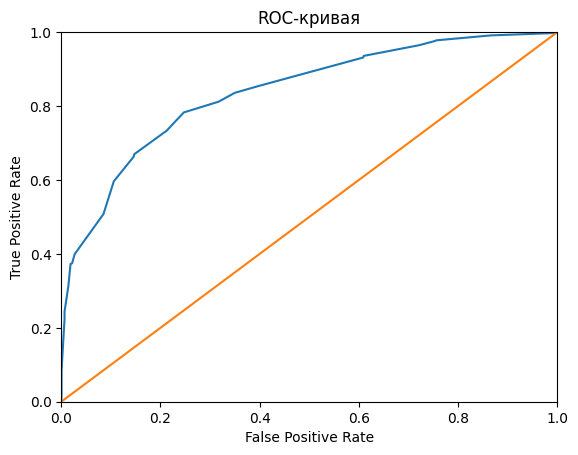

In [28]:
probabilities_valid = best_model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr, linestyle='-')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='-')

# границы осей от 0 до 1
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title('ROC-кривая')
plt.show()

In [29]:
f'Значение AUC-ROC: {roc_auc_score(target_valid, probabilities_one_valid)}'

'Значение AUC-ROC: 0.837473013987699'

То что значение метрики AUC-ROC выше 0.5 показывает, что наша модель работает лучше случайной

Проверим модель на переобучение: посмотрим значение F1-меры на обучающей выборке

In [30]:
predicted_train = best_model_tree.predict(features_train_upsampled)
f1_train = f1_score(target_train_upsampled, predicted_train)
f'Значение F1-меры на обучающей выборке: {f1_train}'

'Значение F1-меры на обучающей выборке: 0.7680650526704861'

На обучающей выборке модель дерева решений показала 0.76 значение F-меры. На валидационной же выборке это значение 0.56. Имеет место проблема переобучения для этой модели

### 3.2.2 Анализ случайного леса

In [31]:
%%time

# Подбор лучших гиперпараметров для случайного леса
best_estimators_forest = 0
best_f1_forest = 0
best_model_forest = None
best_depth_forest = 0

for n_estimators in tqdm(range(10, 105, 5)):
    for depth in range(1, 16 - (n_estimators // 10) + 1, 1):
        model = RandomForestClassifier(random_state=12345, max_depth=max_depth, n_estimators=n_estimators)
        model.fit(features_train_upsampled, target_train_upsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1_forest:
            best_depth_forest = max_depth
            best_f1_forest = f1
            best_model_forest = model
            best_estimators_forest = n_estimators

print(f'Лучшее значение F1-меры: {best_f1_forest}\n'
      f'Лучшая глубина max_depth: {best_depth_forest}\n'
      f'Лучшее количество деревьев n_estimators: {n_estimators}')

  0%|          | 0/19 [00:00<?, ?it/s]

Лучшее значение F1-меры: 0.6049661399548533
Лучшая глубина max_depth: 15
Лучшее количество деревьев n_estimators: 100
CPU times: user 2min 48s, sys: 424 ms, total: 2min 48s
Wall time: 3min 16s


Построим ROC-кривую

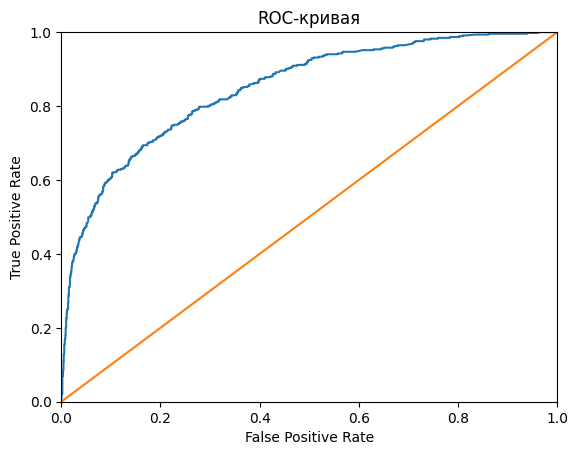

In [32]:
probabilities_valid = best_model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr, linestyle='-')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='-')

# границы осей от 0 до 1
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title('ROC-кривая')
plt.show()

In [33]:
f'Значение метрики AUC-ROC: {roc_auc_score(target_valid, probabilities_one_valid)}'

'Значение метрики AUC-ROC: 0.8473321877715334'

То что значение метрики AUC-ROC выше 0.5 показывает, что наша модель работает лучше случайной

Проверим модель на переобучение: посмотрим значение F1-меры на обучающей выборке

In [34]:
predicted_train = best_model_forest.predict(features_train_upsampled)
f1_train = f1_score(target_train_upsampled, predicted_train)
f'Значение F1-меры на обучающей выборке: {f1_train}'

'Значение F1-меры на обучающей выборке: 0.9949472564488964'

На обучающей выборке модель случайного леса показала 0.99 значение F-меры. На валидационной же выборке это значение 0.60. Моедль сильно переобучена

### 3.2.3 Анализ логистической регресии

In [35]:
%%time

# Подбор лучших гиперпараметров логистической регрессии
best_f1_logistic = 0
best_model_logistic = None
best_iter_logistic = 0

for max_iter in tqdm(range(100, 2001)):
    model = LogisticRegression(random_state=12345, max_iter=max_iter)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1_logistic:
        best_f1_logistic = f1
        best_model_logistic = model
        best_iter_logistic = max_iter

print(f'Лучшее значение F1-меры: {best_f1_logistic}\n'
      f'Лучшее количество итераций: {best_iter_logistic}'
      )

  0%|          | 0/1901 [00:00<?, ?it/s]

Лучшее значение F1-меры: 0.5080091533180778
Лучшее количество итераций: 100
CPU times: user 42.4 s, sys: 316 ms, total: 42.7 s
Wall time: 51.3 s


Построим ROC-кривую

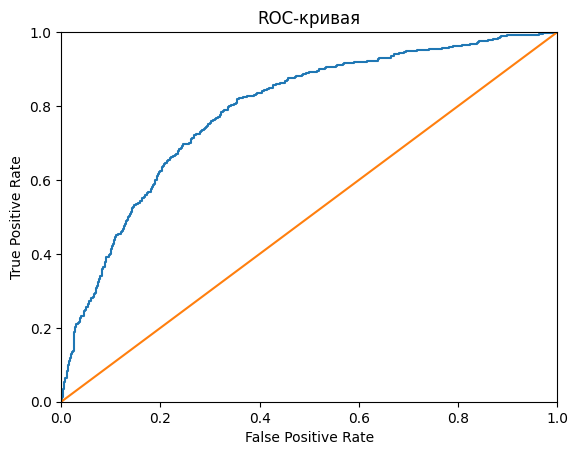

In [36]:
probabilities_valid = best_model_logistic.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr, linestyle='-')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='-')

# границы осей от 0 до 1
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title('ROC-кривая')
plt.show()

In [37]:
f'Значение метрики AUC-ROC: {roc_auc_score(target_valid, probabilities_one_valid)}'

'Значение метрики AUC-ROC: 0.7882495539854112'

То что значение метрики AUC-ROC выше 0.5 показывает, что наша модель работает лучше случайной

Проверим модель на переобучение: посмотрим значение F1-меры на обучающей выборке

In [38]:
predicted_train = best_model_logistic.predict(features_train_upsampled)
f1_train = f1_score(target_train_upsampled, predicted_train)
f'Значение F1-меры на обучающей выборке: {f1_train}'

'Значение F1-меры на обучающей выборке: 0.706389088298636'

На обучающей выборке модель случайного леса показала 0.70 значение F-меры. На валидационной же выборке это значение 0.50. Модель также переобучена

# 4. Вывод

В процессе работы обучена лучшая модель для определения покинет ли клиент банк или нет

Предварительно данные были обработаны (удалены пропуски, удалены бесполезные признаки). Проведены преобразования над категориальными и количественными признаками.

Для моделей:
* дерево решений
* случайный лес
* логистическая регрессия

были вычислены значения F1-меры с учетом дисбаланса классов и без. Для борьбы с дисбалансом использовались различные техники, такие как upsampling, downsampling, class_weight. Дополнительно было исследованно как влияет стратификация при разделении на выборки на исследуемую метрику. Было выяснено, что для дерева решений и случайного леса предварительная стратификация без последующей борьбы с дисбалансом дает лучшие результаты по исследуемой метрике на конкретной выборке. Более стабильно себя показывает техника upsampling, которая в дальнейшем и была выбрана.

Для каждой модели были подобраны такие гиперпараметры, которые максимизируют F1-меру
1. Дерево решений:
    * Параметры: `max_depth = 5`
    * `F1-мера = 0.56`
2. Случайный лес:
    * Параметры: `max_depth = 15`, `n_estimators = 100`
    * `F1-мера = 0.60`
3. Логистическая регресссия:
    * Параметры: `max_iter = 100`
    * `F1-мера = 0.50`

Также для всех трех моделей можно сказать, что ведут они себя лучше чем случайные модели (значение метрики `AUC-ROC` превышают 0.7)

Все 3 модели явно переобучены. Значения F1-меры для обучающей выборки и валидационной заметно различаются в пользу первой.